## Imports

In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Camera calibration

In [2]:
CHESSBOARD_SIZE = (9, 6)

def calibateCamera():
    objpoints = []
    imgpoints = []

    objp = np.zeros((CHESSBOARD_SIZE[0] * CHESSBOARD_SIZE[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:CHESSBOARD_SIZE[0], 0:CHESSBOARD_SIZE[1]].T.reshape(-1, 2)

    img_size = None

    images = glob.glob('camera_cal/calibration*.jpg')
    for image_name in images:
        img = cv2.imread(image_name)

        if img_size is None:
            img_size = (img.shape[1], img.shape[0])

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD_SIZE, None)

        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)
    return cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

_, mtx, dist, rvecs, tvecs = calibateCamera()

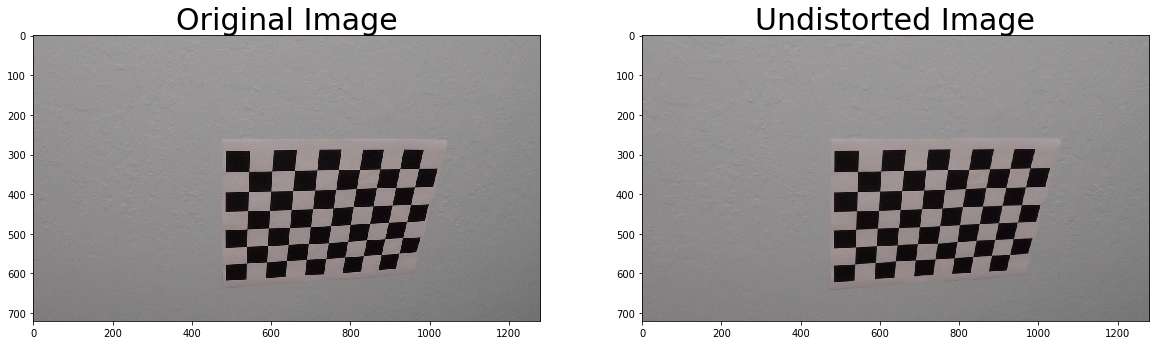

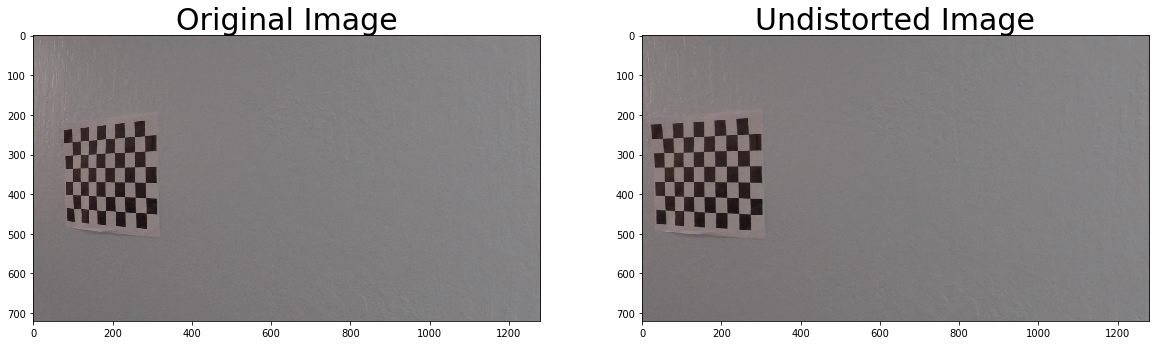

In [3]:
images = glob.glob('camera_cal/calibration*.jpg')
for image_name in images[:3]:
    img = cv2.imread(image_name)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)

# Color channels

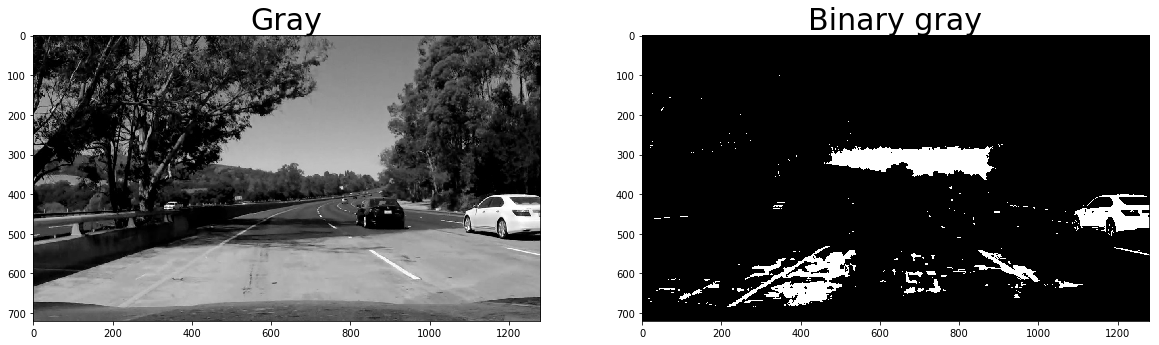

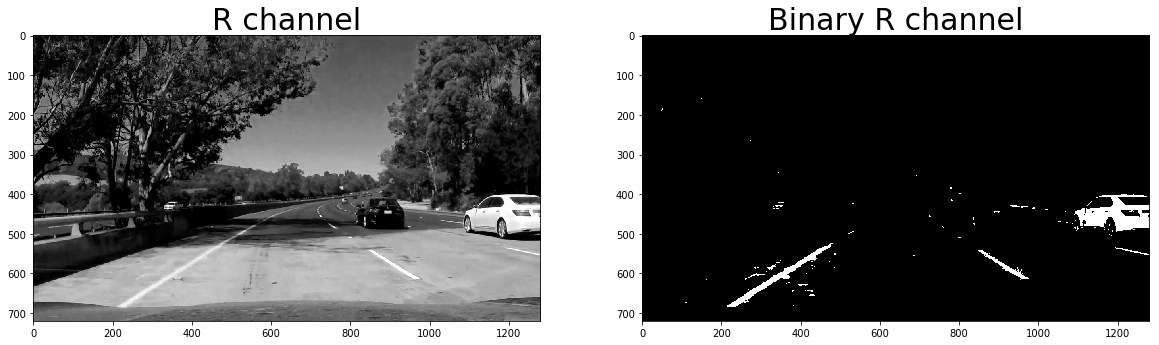

In [4]:
test_image = cv2.imread('test_images/test5.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# gray
gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
binary_gray = np.zeros_like(gray)
binary_gray[(gray > 180) & (gray <= 255)] = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(gray, cmap='gray')
ax1.set_title('Gray', fontsize=30)
ax2.imshow(binary_gray, cmap='gray')
ax2.set_title('Binary gray', fontsize=30)

# red
r_channel = test_image[:,:,0]
binary_r_channel = np.zeros_like(gray)
binary_r_channel[(r_channel > 200) & (r_channel <= 255)] = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(r_channel, cmap='gray')
ax1.set_title('R channel', fontsize=30)
ax2.imshow(binary_r_channel, cmap='gray')
ax2.set_title('Binary R channel', fontsize=30)

# saturation
hls = cv2.cvtColor(test_image, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
binary_s_channel = np.zeros_like(gray)
binary_s_channel[(s_channel > 200) & (s_channel <= 255)] = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(s_channel, cmap='gray')
ax1.set_title('S channel', fontsize=30)
ax2.imshow(binary_s_channel, cmap='gray')
ax2.set_title('Binary S channel', fontsize=30)

## Thresholding

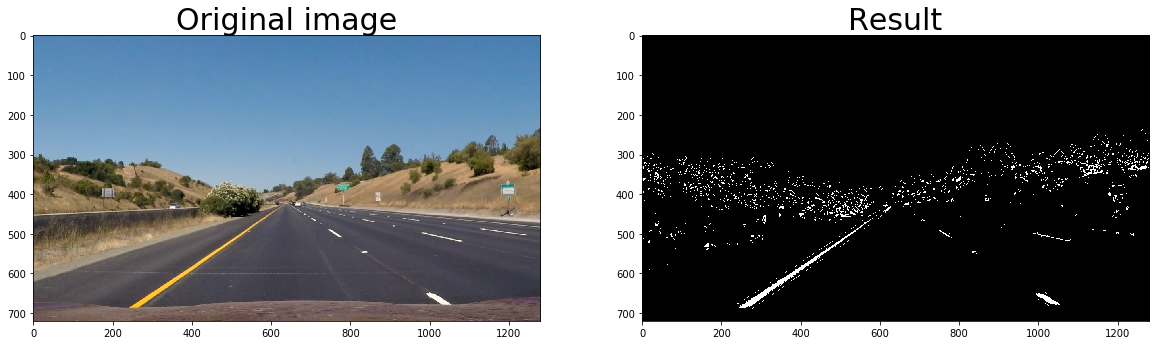

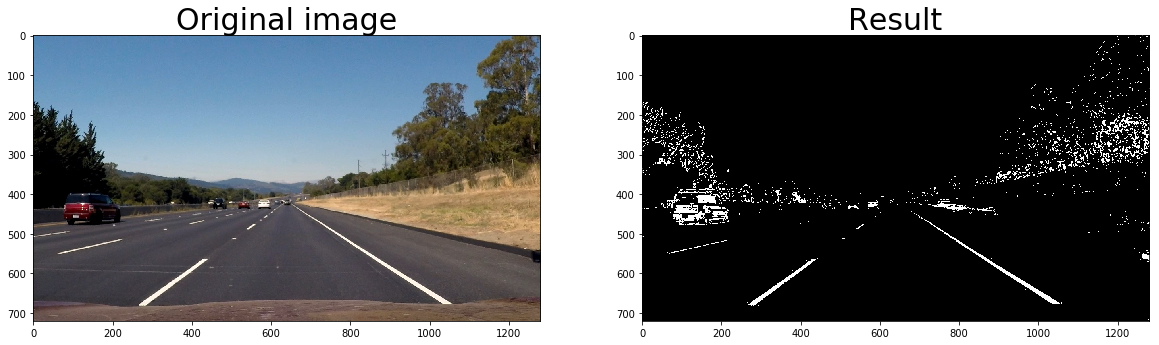

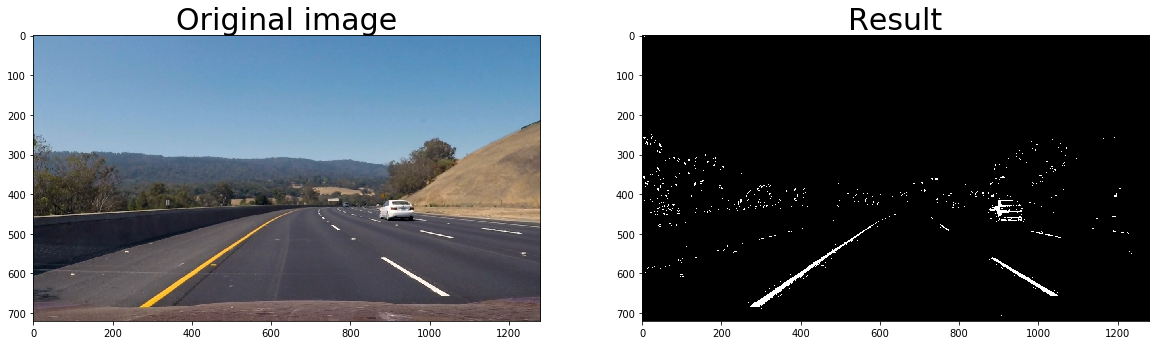

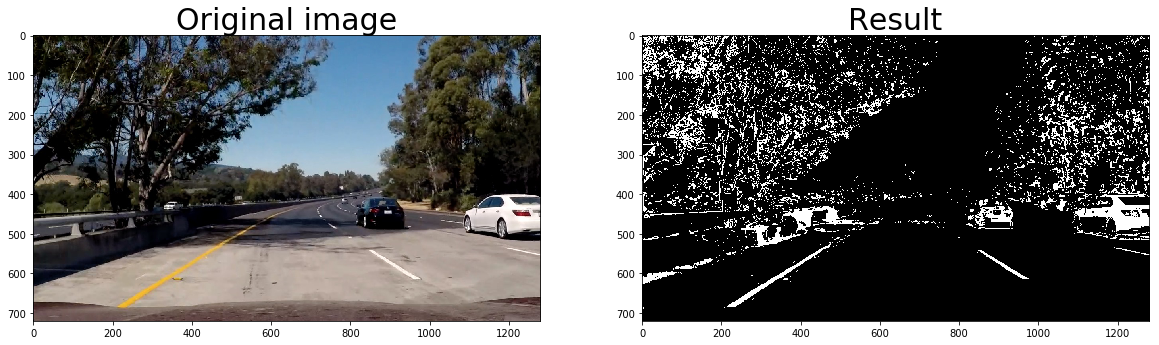

In [5]:
def abs_sobel_thresh(img, orientation='x', kernel=3, thresh=(0, 255)):
    p, q = (1, 0) if orientation == 'x' else (0, 1)
    sobel = cv2.Sobel(img, cv2.CV_64F, p, q, ksize=kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    output = np.zeros_like(scaled_sobel)
    output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return output

def mag_thresh(img, kernel=3, thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def combined_thresholds(img):
    gradx = abs_sobel_thresh(img, orientation='x', kernel=31, thresh=(20, 70))
    
    mag_binary = mag_thresh(img, kernel=31, thresh=(10, 30))
    
    dir_binary = dir_threshold(img, kernel=31, thresh=(0.5, 1.4))
    combined = np.zeros_like(gradx)
    combined[(((gradx == 1) & (mag_binary == 1)) & (dir_binary == 1))] = 1

    return combined

def threshold_pipeline(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gradient_thresh = combined_thresholds(s_channel)

    # red
    r_channel = image[:,:,0]
    binary_r_channel = np.zeros_like(gray)
    binary_r_channel[(r_channel > 220) & (r_channel <= 255)] = 1

    # saturation
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_s_channel = np.zeros_like(gray)
    binary_s_channel[(s_channel > 150) & (s_channel <= 255)] = 1
    
    combined = np.zeros_like(r_channel)
    combined[(gradient_thresh == 1) | ((binary_s_channel == 1)) | ((binary_r_channel == 1))] = 1
    
    return combined


images = glob.glob('test_images/*.jpg')
for image_name in images:
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
#     plt.imshow(image, cmap='gray')
#     plt.show()
    
    output = threshold_pipeline(image)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Original image', fontsize=30)
    ax2.imshow(output, cmap='gray')
    ax2.set_title('Result', fontsize=30)

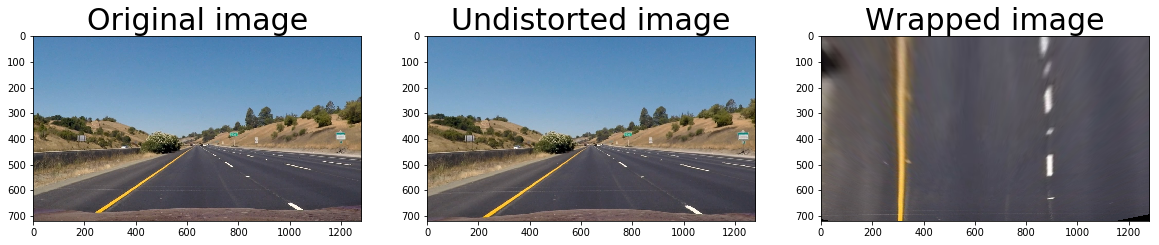

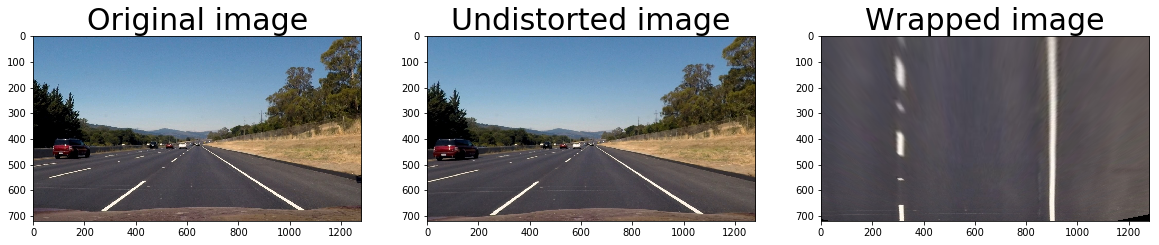

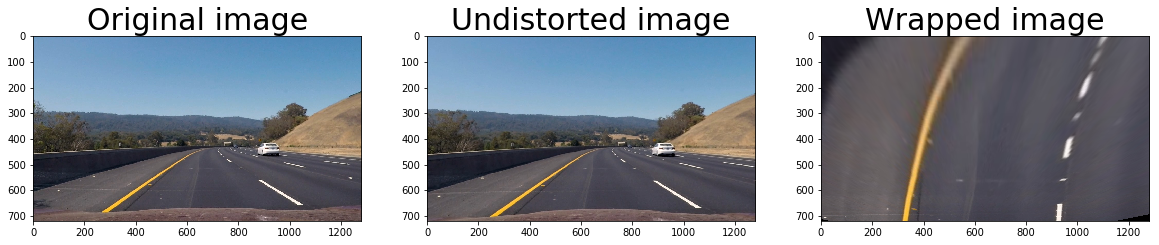

In [6]:
def wrap_perspective(img):
    img_size = img.shape[1::-1]
    src = np.float32([
        [270,670],
        [594,450],
        [689,450],
        [1030,670]
    ])
    dst = np.float32([
        [300,730],
        [300,0],
        [900,0],
        [900,730]
    ])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, Minv


images = glob.glob('test_images/*.jpg')
for image_name in images[:5]:
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    undist_image = cv2.undistort(image, mtx, dist, None, mtx)
    output, _ = wrap_perspective(undist_image)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Original image', fontsize=30)
    ax2.imshow(undist_image, cmap='gray')
    ax2.set_title('Undistorted image', fontsize=30)
    ax3.imshow(output, cmap='gray')
    ax3.set_title('Wrapped image', fontsize=30)

## Processing Each Image

In [7]:
def find_lanes(image, binary_warped):    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    ym_per_pix = 30/720  # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # calculate offset from the lane center
    lane_center = (left_fitx[-1] + right_fitx[-1])/2.0
    camera_center = image.shape[1]/2.0
    offset_center = (lane_center - camera_center) * xm_per_pix

    return left_curverad, right_curverad, offset_center, out_img, (ploty, left_fitx, right_fitx)

In [8]:
def draw_line_detection(image, Minv, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

In [9]:
def make_pipeline(debug=True):
    def pipeline(image):
        undist_image = cv2.undistort(image, mtx, dist, None, mtx)
        theshold = threshold_pipeline(image)

        wrapped, Minv = wrap_perspective(theshold)

        left_curverad, right_curverad, offset_center, out_image, plot_data = find_lanes(image, wrapped)
        center_curverad = (left_curverad + right_curverad) / 2.0

        detected = draw_line_detection(undist_image, Minv, *plot_data)

        curvature_text = 'Curvature: {0:.2f} m'.format(center_curverad)
        offset_center_text = 'Offset: {0:.2f} m'.format(offset_center)

        if debug:
            result = np.zeros((1080, 1920, 3), dtype=np.uint8)
            result[0:720, 0:1280] = detected
            result[0:480, 1280:1920] = cv2.resize(np.dstack((theshold,) * 3) * 255, (640,480), interpolation=cv2.INTER_AREA)
            result[480:960, 1280:1920] = cv2.resize(out_image, (640,480), interpolation=cv2.INTER_AREA)

            text_canvas = np.zeros((360, 1280, 3), dtype=np.uint8)
            font = cv2.FONT_HERSHEY_COMPLEX
            cv2.putText(text_canvas, curvature_text, (30, 60), font, 1.5, (255,255,255), 2)
            cv2.putText(text_canvas, offset_center_text, (30, 120), font, 1.5, (255,255,255), 2)
            result[720:1080, 0:1280] = text_canvas
        else:
            result = draw_text(detected, center_curverad, offset_center)

            canvas = np.zeros_like(image).astype(np.uint8)
            font = cv2.FONT_HERSHEY_COMPLEX
            cv2.putText(canvas, curvature_text, (30, 60), font, 1.5, (255,0,0), 2)
            cv2.putText(canvas, offset_center_text, (30, 120), font, 1.5, (255,0,0), 2)
            result = cv2.addWeighted(image, 1, canvas, 0.3, 0)

        return result
    return pipeline

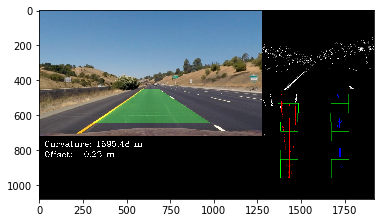

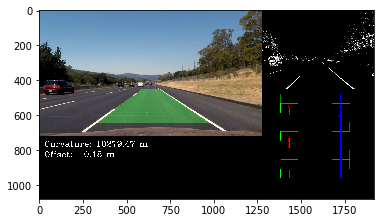

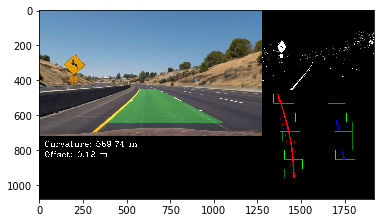

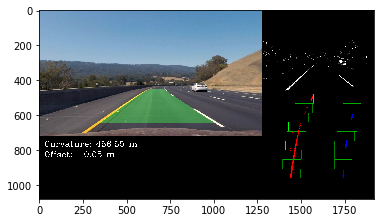

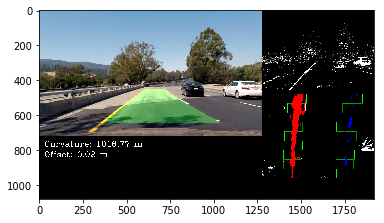

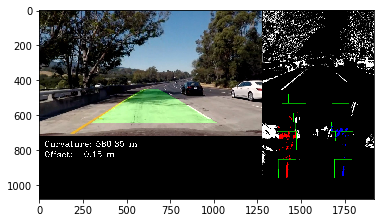

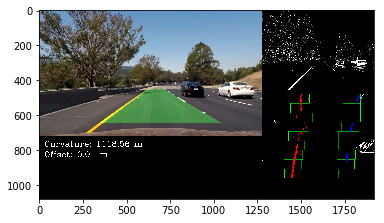

In [10]:
images = glob.glob('test_images/*.jpg')
for image_name in images:
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = make_pipeline(debug=True)(image)
    
    plt.imshow(result)
    plt.show()

In [11]:
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(make_pipeline(debug=True))
white_clip.write_videofile('output.mp4', audio=False, progress_bar=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 



In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output.mp4'))